Code for preprocessing trueref data \
Starting from the aligned pseudodiploid bams, we separate them out into wA 0,1,2 \
Then we get allele specific coverage and sequences accordingly \
We save this temporary result in a data_noGC_trueref.h5 and then perform GC regression on it \
NOTE: This script only generates data_ident_trueref.h5 (only trueref)

In [100]:
# General import, names of train, test, val
%load_ext autoreload
%autoreload 2
import numpy as np
import pysam
from tqdm.notebook import tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng(seed=0)

basedir = '/data/leslie/shared/ASA/'
aligndir = f'{basedir}pseudodiploid/atac/'
ctype = 'treg'
ident = '_vi_150bp'      # ident is '' for you or whatever label you want to use for the h5 data you've generated

datadir = f'{basedir}mouseASA/{ctype}/cast/data/'
chrom_train = [1,2,4,6,7,8,9,11,12,13,14,16,17,18,19]
chrom_val = [3,5]
chrom_test = [10,15]
chroms = [chrom_train, chrom_val, chrom_test]
name = ['train', 'val', 'test']

reps = ['r1','r2','r3','r4']
seqlen = 300                         # region around summit for sequence
seqlen1 = 150                        # region around summit for coverage
save = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing of Model Input

In [101]:
# The bamfile for the standard haploid B6 alignment is called <rep>_ref.bam, which is a little confusing, sorry..
from utils import get_summits, get_shifts, one_hot, GCregress

N = []
for rep in reps:
    bamfile = datadir+'bam/'+rep+'_ref.bam'
    bamf = pysam.AlignmentFile(bamfile, "rb")
    N.append( sum([bamf.get_index_statistics()[i][1] for i in range(len(chrom_train+chrom_test+chrom_val))]) )
    bamf.close()

In [102]:
# process peakatlas file to get peaks dataframe
if ident[:3]=='_vi':  # This is us using a peak atlas, you would be using the else clause here
    summits = pd.read_csv(aligndir+'cd8_old/yi_cd8_peaks_33143.csv',sep=',',index_col=0)
    summits['start'] += seqlen//2
    summits = summits.iloc[:,1:3]
    summits.columns = range(2)
    summits_neg = pd.read_csv(aligndir+'cd8_old/yi_cd8_uneg_peaks_33143.csv',sep=',',index_col=0)
    summits_neg['start'] += seqlen//2
    summits_neg = summits_neg.iloc[:,1:3].reset_index(drop=True)
    summits_neg.columns = range(2)
else:
    if ident=='_yi':
        peakfile = aligndir+'cd8_old/peaks_yi.bed'
    else:
        peakfile = aligndir+ctype+'/peaks/peakatlas.bed'
    peaks = pd.read_csv(peakfile, sep='\t', header=None)

    if not ident:
        # filter peaks based on IDR threshold (column 12 of BED)
        idr_thresh = 0.05
        idx = np.where( peaks.iloc[:,11] >= -np.log10(idr_thresh) )[0]
        peaks = peaks.loc[idx].reset_index(drop=True)

    # remove blacklist regions - try with and without
    blacklistfile = aligndir+'mm10-blacklist.v2.bed'
    blacklist = pd.read_csv(blacklistfile, sep='\t', header=None)
    peaks = remove_blacklist(peaks, blacklist)

    # get summits of called + flanking neg peaks
    summits, summits_neg = get_summits(peaks)

In [103]:
# # Code to shortlist negative flanking summits to low accessibility - not needed if you are doing background unegs
# # Shit code, haven't used in forever, might need overhauling
# if ident[:3]!='_vi':
#     FOR UNEGS, get the shortlist of summits_neg that have low accessibility
#     get indices for each rep
#     idx = dict()
#     for rep in tqdm(reps):
#         bamfile = aligndir+ctype+'/'+rep+'.combined.rmDup.Aligned.sortedByCoord.out.bam'
#         bamf = pysam.AlignmentFile(bamfile, "rb")

#         idx[rep] = []
#         for chrom in chroms[:2]:
#             for c in chrom:
#                 chromsummits = summits_neg.loc[np.where(summits_neg[0]==c)[0]]
#                 y_uneg = []
#                 for i in chromsummits[1]:
#                     y_uneg.append(bamf.count(str(c),i-seqlen//2,i+seqlen//2))
#                 idx[rep] += list(chromsummits.index[ np.where(np.array(y_uneg)<5)[0] ])
#         bamf.close()

#     del y_uneg
#     # get low accessibility indices across reps
#     temp = set(idx[reps[0]])
#     for rep in reps[1:]:
#         temp.intersection_update(idx[rep])
#     idx = list(temp)

#     # shortlist unegs to low accessibility indexes
#     summits_neg = summits_neg.loc[idx].reset_index(drop=True)
#     frac=0.5
#     if len(summits_neg) > frac*len(summits):
#         idx = np.random.choice(len(summits_neg), int(frac*len(summits)), replace=False)
#         summits_neg = summits_neg.loc[idx].reset_index(drop=True)
#     summits_neg = summits_neg.sort_values(by=[0,1], ignore_index=True)

#     if save:
#         summits.to_csv(datadir+'summits'+ident+'.csv', index=False, header=False)
#         summits_neg.to_csv(datadir+'summits_neg'+ident+'.csv', index=False, header=False)

In [104]:
# Augment the list of positive summits in train and val by randomly adding seqlen//3 shifts (100bp)
augment = True      # for augmentation of data by shifting sequence window

if augment:
    ident += '_aug'
    frac = 1.0
    # Randomly shift all the summits by + or - seqlen//3
    summits_aug = summits.copy()
    summits_aug = summits[summits[0].isin(chrom_train+chrom_val)].reset_index(drop=True)
    shifts = seqlen//3 * rng.choice([-1,1], len(summits_aug), replace=True)
    summits_aug[1] += shifts
    # Get total number of summits to be augmented
    temp = np.unique(summits[0], return_counts=True)
    num_aug = int(frac*sum(temp[1][np.isin(temp[0],chrom_train+chrom_val)]))
    # randomly choose the subset of summits to be augmented
    idx = rng.choice(np.arange(len(summits_aug)), num_aug, replace=False)
    summits_aug = summits_aug.iloc[idx, :].reset_index(drop=True)
    summits = pd.concat((summits, summits_aug)).reset_index(drop=True)

In [105]:
# Generate y
# Use summits and BAM files to generate pileup summed accessibilities
y = dict()
for rep in tqdm(reps):
    temp = pysam.AlignmentFile(datadir+'bam/'+rep+'_ref.bam', 'rb')
    
    for n,chrom in zip(name,chroms):
        y[rep+'_'+n] = []

        for c in chrom:        # for each chromosome in train/val/test set
            chromsummits = summits.iloc[np.where(summits[0]==c)[0],1]     # slice out the relevant chromosome summits
            y1 = []
            for i in chromsummits:
                # for each summit peak, get the summed accessibility from BAM pileup
                y1.append(temp.count(str(c),i-seqlen1//2,i+seqlen1//2))
            y[rep+'_'+n] += y1
    temp.close()
    
del y1, chromsummits

# merge RPMs across reps
for n in name:
    y[n] = np.zeros_like(y[rep+'_'+n], dtype=float)
    for i,rep in enumerate(reps):
        y[n] += np.array(y[rep+'_'+n])*1e6/N[i]
        del y[rep+'_'+n]
    y[n] = np.log2(1+y[n])

  0%|          | 0/4 [00:00<?, ?it/s]

In [106]:
# Generate X
from Bio import SeqIO
from bisect import bisect

flank = False             # to take negatives from flanking sequence
gen_b6 = SeqIO.index(f'{basedir}pseudodiploid/gen/b6.fa', 'fasta')

x = dict()
for n,chrom in zip(name,chroms):
    x[n] = []
    if n!='test' and flank:
        x[n+'_unegs'] = []

    for c in tqdm(chrom):        # for each chromosome in train/val/test set
        seq_b6 = ''.join(gen_b6.get_raw(str(c)).decode().split('\n')[1:])
        
        chromsummits = summits.iloc[np.where(summits[0]==c)[0],1]     # slice out the relevant chromosome summits
        
        # get relevant b6 genomic seqs
        x[n] += [seq_b6[i-seqlen//2:i+seqlen//2] for i in chromsummits]
        
        if n!='test' and flank:
            chromsummits = summits_neg.iloc[np.where(summits_neg[0]==c)[0],1]     # slice out the relevant chromosome summits
            x[n+'_unegs'] += [seq_b6[i-seqlen//2:i+seqlen//2] for i in chromsummits]

    x[n] = one_hot(x[n])             # convert string of nucleotides to one-hot representation
    if n!='test' and flank:
        x[n+'_unegs'] = one_hot(x[n+'_unegs'])

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [107]:
# new code for actual background unegs - can be merged into x code later - SKIP till SKIP END if dont need to compute
# written very stupidly, basically just overwrite the old unegs
# this is because I didn't want to write logic to do one or the other depending on which method of unegs you want
from utils import get_neg_summits

if not flank:
    bamfile = datadir+'bam/'+reps[0]+'_ref.bam'     # Note the use of haploid bam
    bamf = pysam.AlignmentFile(bamfile, "rb")
    if 'summits_aug' in locals():
        temp_summits = summits.iloc[:(len(summits)-len(summits_aug)),:]
    elif 'summits_neg' in locals():
        temp_summits = summits.iloc[:len(summits_neg),:]
        
    for n,chrom in zip(name,chroms[:2]):
        x[n+'_unegs'] = []

        for c in tqdm(chrom):        # for each chromosome in train/val/test set
            seq_b6 = ''.join(gen_b6.get_raw(str(c)).decode().split('\n')[1:])

            chromsummits = summits.iloc[np.where(summits[0]==c)[0],1]     # slice out the relevant chromosome summits
            neg_summits = np.empty(0, dtype=np.int64)
            seed=0
            while len(neg_summits)<len(chromsummits):     # get neg summits and only keep low coverage ones (<5)
                temp = get_neg_summits(chromsummits, len(chromsummits)-len(neg_summits), len(seq_b6), seed)
                idx = np.where(np.array([bamf.count(str(c),i-seqlen//2,i+seqlen//2) for i in temp]) < 5)[0]
                temp = temp[idx]
                neg_summits = np.concatenate((neg_summits, temp))
                seed+=1
            neg_summits = np.sort(neg_summits)

            # get relevant b6 genomic seqs
            x[n+'_unegs'] += [seq_b6[i-seqlen//2:i+seqlen//2] for i in neg_summits]

        x[n+'_unegs'] = one_hot(x[n+'_unegs'])

gen_b6.close()

# set uneg log acc to low constant value (at tail end of post-GC residual accessibility distribution)
for n,chrom in zip(name[:2],chroms[:2]):
    y[n+'_unegs'] = -5.0*np.ones(len(x[n+'_unegs']))

# Finally, save everything...
if save:
    with h5py.File(datadir+'data_noGC'+ident+'_trueref.h5','w') as f:
        for key in x.keys():
            f.create_dataset('x_'+key, data=x[key])
        for key in y.keys():
            f.create_dataset('y_'+key, data=y[key])

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

## Perform GC regression

In [108]:
x = dict()
y = dict()
with h5py.File(datadir+'data_noGC'+ident+'_trueref.h5','r') as f:
    for n in name:
        x[n] = f['x_'+n][()]
        y[n] = f['y_'+n][()]
    x['train_unegs'] = f['x_train_unegs'][()]
    x['val_unegs'] = f['x_val_unegs'][()]
    y['train_unegs'] = f['y_train_unegs'][()]
    y['val_unegs'] = f['y_val_unegs'][()]

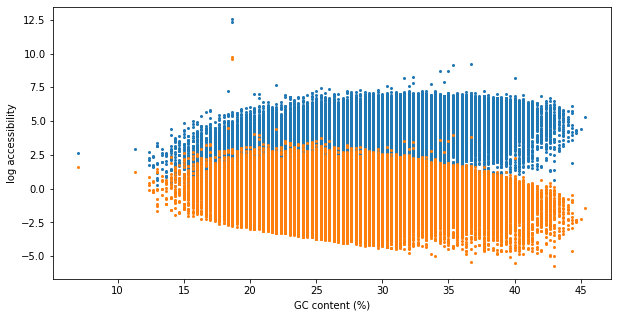

In [109]:
# Visualize the GC-count relationship
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

temp_x = np.vstack([x[k] for k in x.keys() if 'unegs' not in k])
temp_y = np.concatenate([y[k] for k in y.keys() if 'unegs' not in k])
GC = np.sum(temp_x[:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], axis=1)
GC = GC[:,1]+GC[:,2]
ax.scatter(GC/seqlen*100, temp_y, s=4)
coef = GCregress(temp_x[:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], temp_y)    # limit GC counting to only the window where reads are counted
ax.scatter(GC/seqlen*100, temp_y-coef*GC, s=4)
ax.set_xlabel('GC content (%)')
ax.set_ylabel('log accessibility')
plt.show()

In [110]:
# Regress out GC content
temp_x = np.vstack([x[k] for k in x.keys() if 'unegs' not in k])
temp_y = np.concatenate([y[k] for k in y.keys() if 'unegs' not in k])
coef = GCregress(temp_x[:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], temp_y)    # limit GC counting to only the window where reads are counted

del x['test'], y['test']
for n in ['train','val']:
    GC = np.sum(x[n][:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], axis=1)
    GC = GC[:,1]+GC[:,2]
    y[n] -= coef*GC

In [111]:
# Do uneg count adjustment based on range of GC corrected values
print(np.min(y['train']))
print(np.unique(y['train_unegs']))
# y['train_unegs'] -= 5
# y['val_unegs'] -= 5

-5.516182086843912
[-5.]


In [112]:
if save:
    with h5py.File(datadir+'data'+ident+'_trueref.h5','w') as f:
        for key in x.keys():
            f.create_dataset('x_'+key, data=x[key])
            f.create_dataset('y_'+key, data=y[key])